# Técnicas de regularização

Nesta seção, uma rede MLP é treinada no banco de dados [MNIST](https://). Este exemplo ilustra dois aspectos práticos do treinamento de redes neurais: *Dropout* e *Early Stopping*.

![link text](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

CRÉDITOS: o exemplo nesta seção é uma adaptação do existente no link a seguir https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

Agora construímos a rede MLP, mais uma vez implementada como uma subclasse de `torch.nn.Module`. Essa rede será composta de 2 camadas ocultas.

- Camada de entrada: 784 unidades (28 x 28)
- Primeira camada oculta: 128 unidades (neurônios)
- Segunda camada oculta: 128 unidades
- Camada de saída: 10 unidades

Ambas as camadas ocultas usam Dropout para controlar o *overfitting*, com taxa de dropout = 0.5. Elas também são configuradas com a função de ativação ReLU.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Agora, os carregadores para conjuntos de treino, teste e validação são criados.

In [ ]:
batch_size = 128
train_loader, test_loader, val_loader = create_datasets(batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



A função abaixo apresenta o código para treinamento da rede MLP.

Observe que a técnica de regularização **Early Stopping** é usada. A parada antecipada precisa acessar o custo medido no conjunto de validação para verificar se ela diminuiu ou não. Caso o custo tenha diminuído, será feito um *checkpoint* do modelo atual. Um ponto de verificação corresponde a salvar o modelo atual em disco.

Além disso, observe que a função abaixo usou treinamento em minilote. Dessa forma, para a época de treinamento, vários lotes de exemplos são fornecidos à RN e os parâmetros são atualizados para cada lote. O tamanho de cada minilote é passado como argumento para a função.

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, patience, opt_func=torch.optim.SGD):
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    history = dict()
    # to track the average training loss per epoch as the model trains
    history['avg_train_losses'] = []
    # to track the average validation loss per epoch as the model trains
    history['avg_valid_losses'] = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):

        #######################
        # fase de treinamento #
        #######################
        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

        #####################    
        # fase de validação #
        #####################
        model.eval() # prep model for evaluation
        for data, target in val_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        val_loss = np.average(valid_losses)
        history['avg_train_losses'].append(train_loss)
        history['avg_valid_losses'].append(val_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'val_loss: {val_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  history, model

A próxima célula de código define alguns hiperparâmetros. 

- quantidade de épocas de treinamento 
- paciência (que controla a interrupção antecipada do treinamento). 
- função de custo. Para a função de custo, usamos a [entropia cruzada](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), pois estamos construindo um modelo preditivo para classificação. 
- otimizador. Para o otimizador, usamos o [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

- taxa de aprendizado

Após as definições acima, o processo de treinamento é executado.

In [ ]:
epochs = 100

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

criterion = nn.CrossEntropyLoss()

opt_func = torch.optim.Adam

lr = 0.001

history, model = fit(epochs, lr, model, train_loader, val_loader, patience, opt_func)

[  0/100] train_loss: 0.68689 val_loss: 0.25855
Validation loss decreased (inf --> 0.258553).  Saving model ...
[  1/100] train_loss: 0.32892 val_loss: 0.19159
Validation loss decreased (0.258553 --> 0.191593).  Saving model ...
[  2/100] train_loss: 0.26206 val_loss: 0.15637
Validation loss decreased (0.191593 --> 0.156371).  Saving model ...
[  3/100] train_loss: 0.23626 val_loss: 0.13884
Validation loss decreased (0.156371 --> 0.138845).  Saving model ...
[  4/100] train_loss: 0.20946 val_loss: 0.12977
Validation loss decreased (0.138845 --> 0.129773).  Saving model ...
[  5/100] train_loss: 0.19542 val_loss: 0.11933
Validation loss decreased (0.129773 --> 0.119333).  Saving model ...
[  6/100] train_loss: 0.18170 val_loss: 0.12386
EarlyStopping counter: 1 out of 20
[  7/100] train_loss: 0.17400 val_loss: 0.11205
Validation loss decreased (0.119333 --> 0.112053).  Saving model ...
[  8/100] train_loss: 0.16536 val_loss: 0.10840
Validation loss decreased (0.112053 --> 0.108402).  Sav

Como os custos de treino e validação foram rastreadas durante o treinamento, podemos plotar seus valores. Isso é feito na célula de código abaixo.

O gráfico gerado apresenta duas curvas, uma para os custos de treinamento e outra para os custos de validação. Uma linha vermelha pontilhada também é apresentada. Esta linha corresponde ao momento em que o melhor modelo (conforme medido no conjunto de validação) é gerado. Observe também que o processo de treinamento continua após esse momento por mais algumas épocas, devido ao valor do hiperparâmetro *patience*.

Uma coisa que pode parecer estranha no início é que o erro no conjunto de dados do trem é maior do que o erro no conjunto de validação. No entanto, este é um comportamento esperado, uma vez que o dropout está sendo utilizado. Para obter mais detalhes sobre isso, consulte a discussão [aqui](stats.stackexchange.com/questions/187335/validation-error-less-than-training-error).

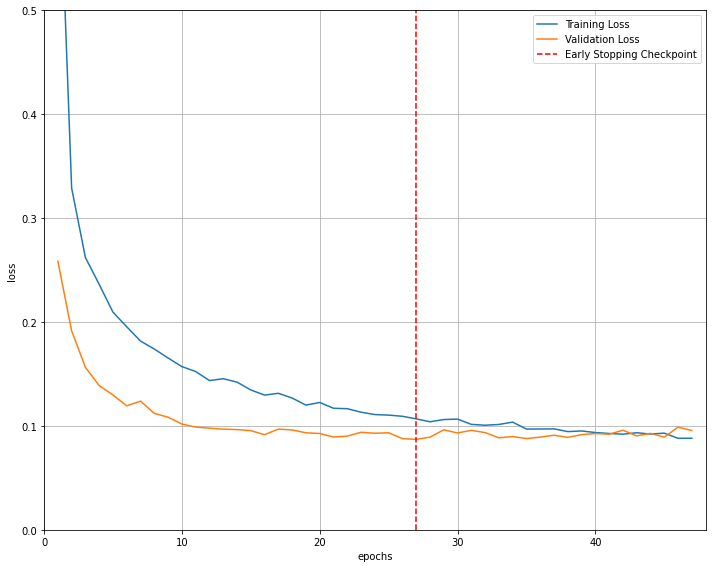

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(history['avg_train_losses'])+1),history['avg_train_losses'], label='Training Loss')
plt.plot(range(1,len(history['avg_valid_losses'])+1),history['avg_valid_losses'],label='Validation Loss')

# find position of lowest validation loss
minposs = history['avg_valid_losses'].index(min(history['avg_valid_losses']))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(history['avg_train_losses'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Agora que o processo de treinamento está finalizado, podemos avaliar o modelo gerado com relação ao seu desempenho preditivo. Para isso, usamos os exemplos do conjunto de teste.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.084696

Test Accuracy of     0: 99% (970/979)
Test Accuracy of     1: 98% (1121/1133)
Test Accuracy of     2: 98% (1012/1030)
Test Accuracy of     3: 97% (982/1008)
Test Accuracy of     4: 98% (961/980)
Test Accuracy of     5: 97% (865/890)
Test Accuracy of     6: 97% (936/956)
Test Accuracy of     7: 97% (999/1027)
Test Accuracy of     8: 96% (935/973)
Test Accuracy of     9: 96% (972/1008)

Test Accuracy (Overall): 97% (9753/9984)


Como um teste de sanidade, também podemos imprimir algumas das imagens de exemplo no conjunto de dados de teste, juntamente com o rótulo previsto para cada uma delas.

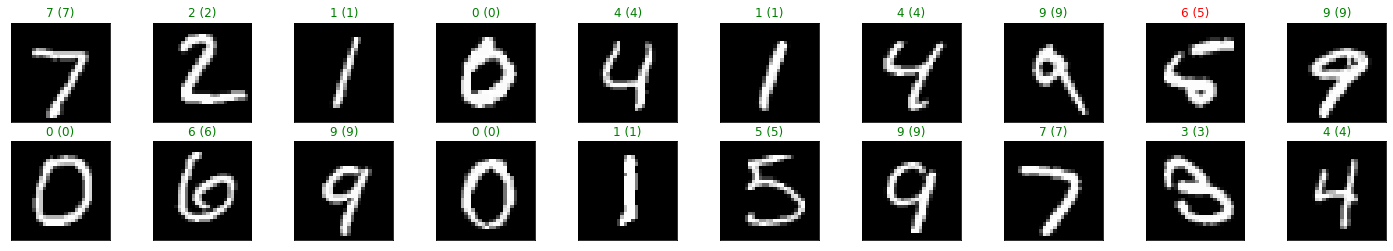

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))